In [27]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

from sklearn.preprocessing import normalize as norm

In [29]:
ls

Analysis/                            ax3_figure.pdf
Fit/                                 ax3_figure.png
Fit completo_ch0_ch1_ch2.ipynb       bad_voltage.ipynb
Fit_all_prova_bozza.ipynb            batch3.ipynb
InterCalibrazione - Foglio1.csv      cfd.ipynb
InterCalibrazione - Test.csv         file.root
InterCalibrazione-2.xlsx             fit_ch0.ipynb
InterCalibrazione.xlsx               fit_ch0_ch1_ch2_bis.ipynb
Run_allch_TEST_7M_4_12_2024.dat.npz  fit_ch1.ipynb
Spectrum_analysis_general.ipynb      fit_ch2.ipynb
Timing carca.ipynb                   fit_ch6.ipynb
Timing waveforms copia.ipynb         fit_ch7 .ipynb
Timing waveforms.ipynb               intercalibrazione.png
Timing waveforms2.ipynb              intercalibrrazione copia.ipynb
Timing.ipynb                         intercalibrrazione.ipynb
Untitled-1.ipynb                     linearity_Na.ipynb
WaveCatcherParams_new.ipynb          ortho_filter.ipynb
analisi_trigger.ipynb                pyroot_data_handling.ipynb
ax1_figure.pd

In [72]:
FILE_PATH = "../Dati/Run_Na_cfd_7_16_5_13_2024_Ascii.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show() #Display contents

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
ratecount            | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [73]:
print(type(file["tree"]["base"].array()))
bl=file["tree"]["base"].array()
print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file["tree"]["ch"].array()
print(nch)

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 16]
[16]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [74]:

baselines = np.array(file["tree"]["base"].array()) 
charges = np.array(file["tree"]["charge"].array())
amp = np.array(file["tree"]["amp"].array())
lead_edge = np.array(file["tree"]["letime"].array())
t_edge = np.array(file["tree"]["tetime"].array())
channel= np.array(file["tree"]["ch"].array())
waveform = np.array(file["tree"]["pshape"].array())

In [75]:
N_ev=len(baselines)
print(N_ev)

3000


In [76]:
canale=[4,5,6,7,8,9,10,11,12,13,14,15]
#l'ultimo è il 15
carica_gamma=np.array([0,0,0,0, -440, -740, 0, -740,0,0, -280, -430, -450,  -660, -650,  -940 ])


coppia=np.array([ [4,5], [10,11], [12,13], [14,15] ])

firstch = coppia[:,0]
secondch = coppia[:,1]

map = np.repeat(-1,16)

for i in range(16):
    if np.where(coppia.flatten()==i)[0].size>0:
        map[i]=np.where(coppia.flatten()==i)[0]
print(map)

n=5
firstch_limits=    [  [carica_gamma[coppia[i][0]]+n*0.07*carica_gamma[coppia[i][0]], carica_gamma[coppia[i][0]]-n*n*0.07*carica_gamma[coppia[i][0]] ] for i in range(len(coppia))]
secondch_limits= [  [carica_gamma[coppia[i][1]]+n*0.07*carica_gamma[coppia[i][1]], carica_gamma[coppia[i][1]]-n*0.07*carica_gamma[coppia[i][1]] ] for i in range(len(coppia))   ]

print(carica_gamma)
print(firstch_limits)
print(secondch_limits)

[-1 -1 -1 -1  0  1 -1 -1 -1 -1  2  3  4  5  6  7]
[   0    0    0    0 -440 -740    0 -740    0    0 -280 -430 -450 -660
 -650 -940]
[[-594.0, 330.0000000000001], [-378.0, 210.00000000000006], [-607.5, 337.5000000000001], [-877.5, 487.5000000000002]]
[[-999.0, -481.0], [-580.5, -279.5], [-891.0, -429.0], [-1269.0, -611.0]]


In [77]:
paired_amp_1 = []
paired_charge_1 = []
paired_letime_1 = []
paired_wf_1 = []

paired_amp_2 = []
paired_charge_2 = []
paired_letime_2 = []
paired_wf_2 = []

whichpair=[]


for event in range(N_ev):
    for channel1, channel2, limF, limS in zip(map[firstch],map[secondch],firstch_limits,secondch_limits):
        #controllo se c'è un evento nel primo della coppia
        if(charges[event][channel1] >= limF[0] and charges[event][channel1] <= limF[1]):
            #se sì, vedo se ce n'è uno anche nel secondo della coppia
            if (charges[event][channel2] >= limS[0] and charges[event][channel2] <= limS[1]):
                #salvo i parametri del primo canale della coppia
                whichpair.append(channel1)

                paired_amp_1.append(amp[event][channel1])
                paired_charge_1.append(charges[event][channel1])
                paired_letime_1.append(lead_edge[event][channel1])
                paired_wf_1.append(waveform[event][channel1])

                paired_amp_2.append(amp[event][channel2])
                paired_charge_2.append(charges[event][channel2])
                paired_letime_2.append(lead_edge[event][channel2])
                paired_wf_2.append(waveform[event][channel2])

#import gc
#del waveform
#gc.collect()

161
9


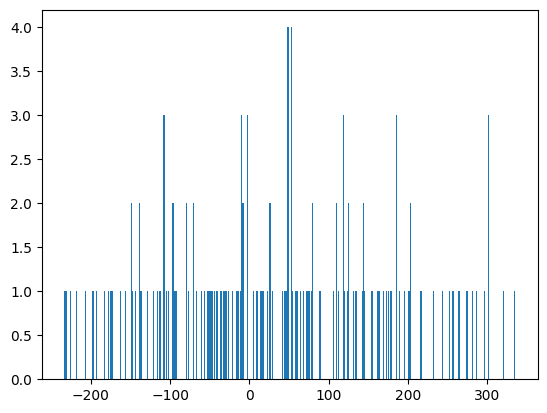

In [78]:
timeres=np.array(paired_letime_1) - np.array(paired_letime_2)
print(len(timeres))
a=plt.hist(timeres, bins=400)
print( (np.abs(timeres)<10).sum())


129.124 208.766


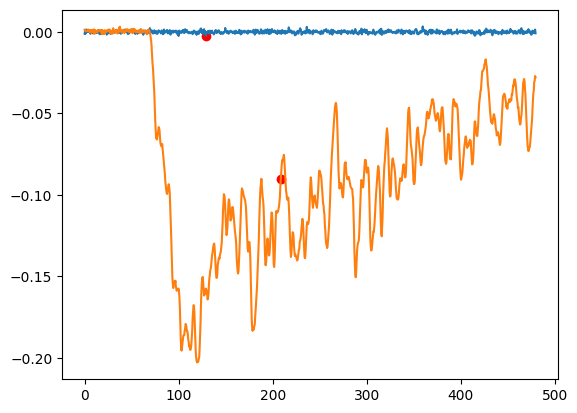

In [83]:
time=np.arange(1024)
sampling=0.4688
i=7
n_sigma=7
plt.plot(time*sampling, paired_wf_1[i] )
plt.plot(time*sampling, paired_wf_2[i])
print(paired_letime_1[i], paired_letime_2[i])

idx1=int(paired_letime_1[i]/sampling)
idx2=int(paired_letime_2[i]/sampling)
plt.scatter(paired_letime_1[i], paired_wf_1[i][idx1], color='r')
plt.scatter(paired_letime_2[i], paired_wf_2[i][idx2], color='r')